# Instructions
1. Read through the code and descriptions, make sure you understand each line of code.
2. There is functionality missing in the functions `show_posterior_surface` and  `draw_sample_models`.  Fill in the missing functionality.
3. Answer the questions at the end of the worksheet.
4. Submit your completed worksheet to your pre-class work GitHub repository before the start of class.

# Bayesian linear models

This script provides a very basic introduction to making prediction with Bayesian linear models.
Some of the functionality is missing and will need to be added before the entire script works.

First we generate a data set.  Since this dataset is randomly generated, each time you run this cell you will get a new dataset to observe:

<IPython.core.display.Javascript object>


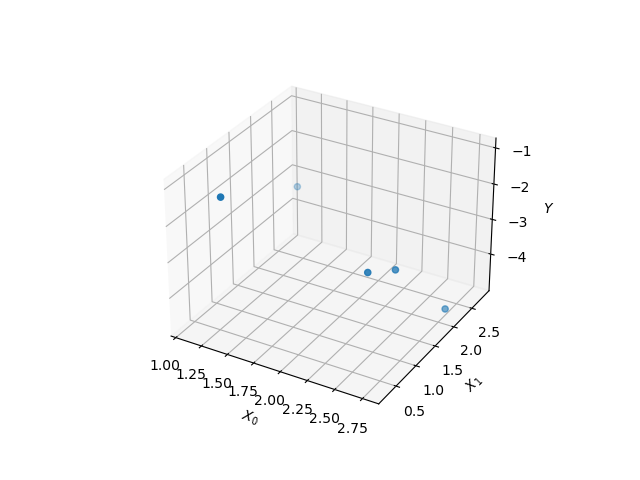

In [9]:
# If you are running this notebook locally  with ipython use:
%matplotlib notebook
# and you will get beautiful rotatable graphs!

import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import BayesianRidge
#add the library for normalizing
from sklearn import preprocessing
#add the library for un-logging the posterior
import math

TRUE_MODEL_WEIGHTS = np.array([-1.0, -1.0])
N = 5 #5 data points
shape = (N, 2) #data points with 2 columns(x0 and x1)
sigma = 1.0
vmax = 3

#this might be better if I can say x_1 x_0 or axis 1, axis 2
#axis used for flattening the 3d graphs, and generating models using these axis1, axis2 values
w_1 = np.arange(-3, 3, 0.1) #all the values between -3 and 3 with interval of 0.1
w_2 = np.arange(-3, 3, 0.1)


def linear(w, x):
    #product of vectors
    return np.dot(w, x.T)

#a code to generate data
def rand_inputs(shape, vmax):
    #3*random number per each data
    #generate random number for x0 and x1 for 5 datapoints
    #generate 5 datapoints
    return vmax * np.random.rand(*shape)

#generate y values for each data points
def rand_outputs(inputs, sigma):
    #sum of(-1*input x values) = y value
    true_output = linear(TRUE_MODEL_WEIGHTS, inputs)
    #making some noise on each of data points 
    noise = sigma * np.random.rand(*true_output.shape)
    return true_output + noise


xs = rand_inputs(shape, vmax)
ys = rand_outputs(xs, sigma)


def plot_data(title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs[:, 0], xs[:, 1], ys)
    ax.set_xlabel('$X_0$')
    ax.set_ylabel('$X_1$')
    ax.set_zlabel('$Y$')
    if title is not None:
        plt.title(title)

    return ax


_ = plot_data()


### Likelihood
Given the data, we can now look at the likelihood of the data.
Strictly speaking, this is a continuous function, but we will approximate this continuous function with a multidimensional grid of points over a plausible area of the model parameters.  In the figure below we plot the log-likelihood function since this is much nicer to visualize (as well as being more numerically stable).

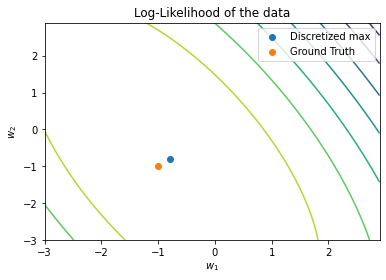

In [2]:
def loglikelihood(w, x, y, sigma):
    #likelihood of data, but as they are logged, we are adding the whole thing
    #addition will mean multiplication in actual likelihood distribution
    #we are generating the likelihood distribution of p(data|parameters)
    #this is the sum of differences between actual y and y estimates
    #but divided by the sigma(standard deviation)
    return -sum((y - np.dot(w, x.T))**2) / sigma

#flatten the 3d to 2d 
def standard_plot(Z, title=None):
    plt.figure()
    max_ind = np.unravel_index(Z.argmax(), Z.shape)
    #contour plot to make 3d to 2d
    plt.contour(w_1, w_2, Z)
    plt.scatter(w_1[max_ind[0]], w_2[max_ind[1]], label="Discretized max")
    plt.scatter(
        TRUE_MODEL_WEIGHTS[0], TRUE_MODEL_WEIGHTS[1], label="Ground Truth")
    plt.legend()
    plt.xlabel("$w_1$")
    plt.ylabel("$w_2$")
    if title is not None:
        plt.title(title)

def show_log_likelihood_surface(x, y, sigma, estimates=None):
    Z = np.zeros((w_1.size, w_2.size))

    for (i, w_i) in enumerate(w_1):
        for (j, w_j) in enumerate(w_2):
            w_hat = np.array([w_i, w_j])
            Z[i, j] = loglikelihood(w_hat, x, y, sigma)

    standard_plot(Z, "Log-Likelihood of the data")
    return Z


log_likelihood = show_log_likelihood_surface(xs, ys, 1.0)



### Prior
As good Bayesians, we also provide a prior belief over our model parameters.  In this case we use a Normal distribution centered around zero to encode our belief that the weights are not large (i.e. far from zero).  Again we are plotting everything in log-space.

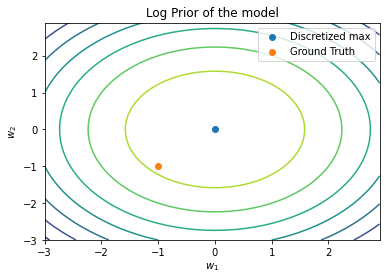

In [3]:
#add normal in the function [mean=0, weights are small = far from 0 = high std]
def show_log_prior_surface(sigma):
    W_1, W_2 = np.meshgrid(w_1, w_2, sparse=False, indexing='ij')
    W_1 = -(W_1**2)
    W_2 = -(W_2**2)
    Z = (W_1 + W_2) / sigma
    
    #generate the functions
    standard_plot(Z, "Log Prior of the model")
    return Z


log_prior = show_log_prior_surface(1.0)


### Posterior
Since our prior and likelihood plots have been in log-space we can get the posterior plot through simple addition (since addition in log-space corresponds to multiplication in normal space). However it is useful to also see the actual posterior.

### Task
1. Write code to transform the data into a proper posterior distribution.  Since the distribution is given in log-space, you will need to exponentiate the distribution and normalize it, so that it sums to 1.

<IPython.core.display.Javascript object>


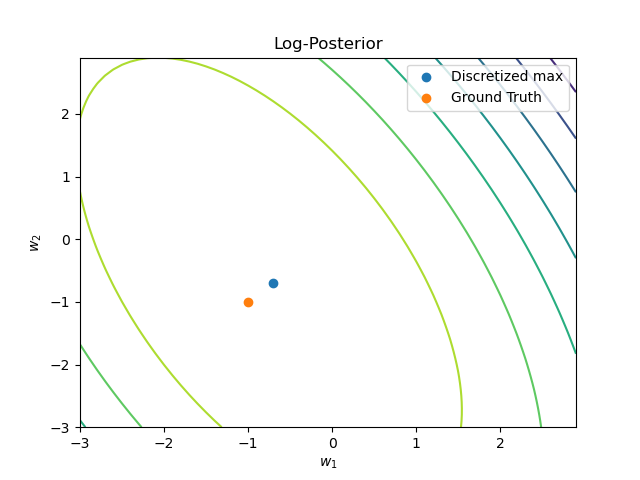

<IPython.core.display.Javascript object>


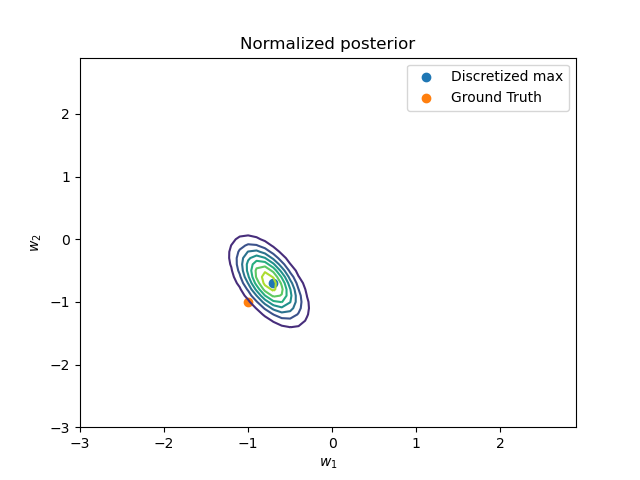

[[3.05648415e-069 1.41882461e-065 4.99756451e-062 ... 1.45885384e-051
  9.94802242e-055 5.14736373e-058]
 [4.05192174e-067 1.69844541e-063 5.40213292e-060 ... 5.76019852e-052
  3.54687924e-055 1.65721358e-058]
 [4.79342176e-065 1.81434622e-061 5.21096093e-058 ... 2.02959233e-052
  1.12850047e-055 4.76121510e-059]
 ...
 [3.42899389e-027 4.74089181e-026 4.97366475e-025 ... 1.70295084e-153
  3.45870763e-159 5.33026404e-165]
 [6.89779298e-028 8.61167175e-027 8.15807905e-026 ... 1.02031042e-156
  1.87123375e-162 2.60403545e-168]
 [1.23822422e-028 1.39592018e-027 1.19411184e-026 ... 5.45516925e-160
  9.03416310e-166 1.13524802e-171]]


In [26]:
def show_log_posterior_surface(prior, likelihood):
    #when things are log-ed 
    #multiplication becomes addition
    Z = prior + likelihood
    standard_plot(Z, "Log-Posterior")
    return Z

#I have two versions, but they seem to have different outcome (but same process tho)
def show_posterior_surface1(log_posterior):
    # TODO: Let's turn this into a proper probability distribution!
    #posterior is normalized term of (likelihood*prior)
    #but we have logged the whole thing
    posterior = preprocessing.normalize(math.e**log_posterior)
    
    standard_plot(posterior, "Normalized posterior")
    return posterior
#the one that looks more plausible
def show_posterior_surface(log_posterior):
    # TODO: Let's turn this into a proper probability distribution!
    #posterior is normalized term of (likelihood*prior)
    #but we have logged the whole thing
    #so, un-log them by e^(log_posterior)
    #then, normalize them
    posterior = np.exp(log_posterior)/np.sum(np.exp(log_posterior))
    
    standard_plot(posterior, "Normalized posterior")
    return posterior

log_posterior = show_log_posterior_surface(log_prior, log_likelihood)
posterior = show_posterior_surface(log_posterior)
print(posterior)

### Samples
Now that we have a proper (discrete) distribution, we can draw samples from the distribution and show the predictions that those models make.

##### Task
1. Write code to draw `n` samples from the posterior distribution.  Here a single sample will return an entire model (this model is parameterized by the tuple `(w_1,w_2)`, so a single sample should return those two parameters).

<IPython.core.display.Javascript object>


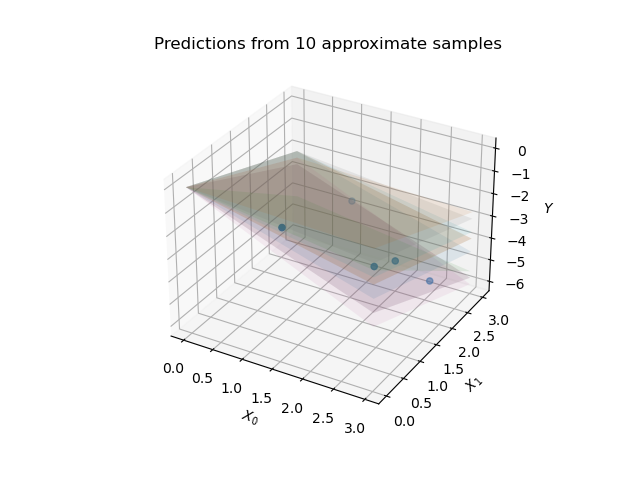

In [32]:
# Draw some samples from the posterior!
np.random.seed(42)
def draw_sample_models(n, posterior):
    # Hint: the code below is not actually sampling from a posterior!
    # TODO: Make it sample from the posterior!
    #We could have generated a better data. 
    #But as we have a discrete data points for the distribution, we only can choose from existing data points of the posterior dist rather than calling from posterior distribution mathematical function
    #What I mean is choosing samples from what is already generated
    sample = np.zeros((n,2))
    for i in range(n):
        random = np.random.choice(3600, p = posterior.flatten())
        sample[i, 0] = w_1[random//60]
        sample[i, 1] = w_2[random%60]
    return sample

N_samples = 10
ws = draw_sample_models(N_samples, posterior)
flat_posterior = posterior.flatten()


def show_model(ax, w):
    X = np.array([[0.0, 0.0], [0.0, vmax], [vmax, 0.0], [vmax, vmax]])
    X0 = X[:, 0].reshape((2, 2))
    X1 = X[:, 1].reshape((2, 2))

    Z = linear(w, X).reshape((2, 2))
    ax.plot_surface(X0, X1, Z, alpha=1.0 / N_samples)


ax = plot_data("Predictions from 10 approximate samples")
for ind in range(N_samples):
    show_model(ax, ws[ind,:])



### `scikit.learn.BayesianRidge`
In this particular case the model is simple enough that we don't need to use a discrete approximation and can instead find analytical solutions.  This has been coded up into `BayesianRidge` and is a part of scikit.learn.  When examining the results, notice that the error bars for the predictions increase as we move away from data that has already been seen.

##### Task
1. Find the online documentation for `BayesianRidge` to determine what model is being fitted, and what the parameters and hyperparameters are.

(Note that the `return_std` option was only recently added to BayesianRidge (Dec 2016). If the code fails then please try updating your version of scikit.learn!)

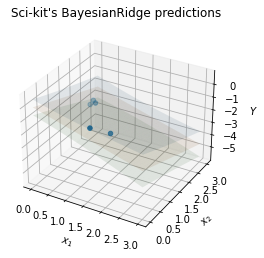

In [6]:
N_grid = 30


def error_bars(clf, title=None):
    x = np.linspace(0, vmax, N_grid)
    X0, X1 = np.meshgrid(x, x)
    X = np.vstack((X0.flatten(), X1.flatten())).T
    Y_hat, Y_std = clf.predict(X, return_std=True)
    Y_hat = Y_hat.reshape((N_grid, N_grid))
    Y_std = Y_std.reshape((N_grid, N_grid))

    ax = plot_data()

    ax.plot_surface(X0, X1, Y_hat + 1.96 * Y_std, alpha=0.1, label="Lower")
    ax.plot_surface(X0, X1, Y_hat, alpha=0.1, label="Mean")
    ax.plot_surface(X0, X1, Y_hat - 1.96 * Y_std, alpha=0.1, label="Upper")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    if title is not None:
        plt.title(title)


clf = BayesianRidge(compute_score=True, fit_intercept=False)
clf.fit(xs, ys)
error_bars(clf, "Sci-kit's BayesianRidge predictions")


### Questions

1. Given that we now have a number of models drawn from a posterior, how should we make a prediction for a single point?
2. How do the models' predictions behave for points far away from observed data?
3. What model does the maximum likelihood model correspond to?
4. How does the behavior of the Bayesian linear model change as we observe more data?
5. What other steps does the scikit learn BayesianRidge perform that we don't (list all of them)
6. What hyperparameter(s) are in this model?
7. Why don't we approximate more posterior distributions with a multi-dimensional grid of points?
8. What are the similarities and differences between Bayesian & frequentist approaches to statistics?

1. [Answer] we can average the 10 different distribution's answer

2. [Answer] It is less likely to get the ones far away from the observed data, however, by allowing bigger variance, we still can claim larger distanced data points. 

3. [Answer] ML model allows us to guess the distributions of the parameters! Especially, when we want to get a specific data point, MAP can be used. (get the mode)

4. The more data we have, the less variance we have! (tighter distributions and less variance in the sample generation)

5. We could have optimized alpha and lambda that are the precisions of the Gaussian distribution. 

6. We still do have the alpha(precision of noise) and lambda(precision of data)

7. I don't think it is necessary at this point. We need more data to make things more better rather than building up bunch of posterior distributions. At this point, I am even unsure howmany distributions we need. Already the existing ones are similar with each other

8. Similarity is that they both need a lot of data to make things more specific. However, Bayesian approach considers all the parameters as a distribution. So, it allows us to have more space in guessing the distribution. 